In [1]:
import pandas as pd
import numpy as np
import matplotlib

from ecog_speech import datasets, feature_processing, models, utils
%matplotlib inline

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


Data from all patient_tuples is read and parsed for speaking/no-speaking regions (can be extended to other objectives)

In [4]:
nww = datasets.NorthwesternWords(patient_tuples=[('Mayo Clinic', 19, 1, 1)])

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


---19-1-1-Mayo Clinic---
Duplicate words (n=2): pig, cup
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Selected sensors (n=64): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Audio shape: (16887643,) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.825875'))]

------------------------------
Processing: ('Mayo Clinic', 19, 1, 1)
[0] default_preprocessing()
	->Outputs: start_times_d, stop_times_d
[1] stim_adjust__power_quantile(q)
	->Outputs: stim_pwrq, stim_pwrq_diff, rolling_audio_pwr


### nww dataset

#### The a flat mapping of objects describing the sample windows is stored as `flat_index_map`
- First 3 keys and values below
- Key must identify the class as well as sample id (first two positions)

In [5]:
list(nww.flat_index_map.keys())[:3], list(nww.flat_index_map.values())[:3]

([(1, 0, 'Mayo Clinic', 19, 1, 1),
  (1, 1, 'Mayo Clinic', 19, 1, 1),
  (1, 2, 'Mayo Clinic', 19, 1, 1)],
 [TimedeltaIndex(['0 days 00:04:55.390833333', '0 days 00:04:55.391666667',
                     '0 days 00:04:55.392500', '0 days 00:04:55.393333333',
                  '0 days 00:04:55.394166667',    '0 days 00:04:55.395000',
                  '0 days 00:04:55.395833333', '0 days 00:04:55.396666667',
                     '0 days 00:04:55.397500', '0 days 00:04:55.398333333',
                  ...
                     '0 days 00:04:55.882500', '0 days 00:04:55.883333333',
                  '0 days 00:04:55.884166667',    '0 days 00:04:55.885000',
                  '0 days 00:04:55.885833333', '0 days 00:04:55.886666667',
                     '0 days 00:04:55.887500', '0 days 00:04:55.888333333',
                  '0 days 00:04:55.889166667',    '0 days 00:04:55.890000'],
                 dtype='timedelta64[ns]', length=600, freq=None),
  TimedeltaIndex(['0 days 00:04:55.400833333'

#### Flat numpy array of tuples of keys - this is where we select into the data and get keys to other mapping structures

In [6]:
nww.flat_keys

array([[(1, 0, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(1, 1, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(1, 2, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       ...,
       [(-1, 57, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(-1, 58, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(-1, 59, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)]],
      dtype=object)

In [7]:
nww.__len__??

Signature: nww.__len__()
Docstring: <no docstring>
Source:   
    def __len__(self):
        return len(self.selected_flat_keys)
File:      ~/Projects/CMSCResearch/ECOGSpeech/ecog_speech/datasets.py
Type:      method


In [8]:
nww.__getitem__??

Signature: nww.__getitem__(item)
Docstring: <no docstring>
Source:   
    def __getitem__(self, item):
        # ix_k includes the class and window id
        # data_k specifies subject dataset in data_map (less granular than ix_k)
        ix_k, data_k = self.selected_flat_keys[item]
        data_d = self.data_map[data_k]

        # Put it all together (TODO: cleanup this interface)
        so = self.make_sample_object(self.flat_index_map[ix_k],
                                     ix_k[0], data_d['ecog'],
                                     data_d['audio'],
                                     ecog_transform=self.transform,
                                     #max_ecog_samples=self.max_ecog_window_size,
                                     mfcc_f=self.mfcc_m)
        # Return anything that is a Torch Tensor
        return {k: v for k, v in so.items()
                if isinstance(v, torch.Tensor)}
File:      ~/Projects/CMSCResearch/ECOGSpeech/ecog_speech/datasets.py
Type:      metho

In [9]:
nww.flat_keys[:3,]

array([[(1, 0, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(1, 1, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)],
       [(1, 2, 'Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 1)]],
      dtype=object)

In [10]:
nww.flat_keys.shape

(13800, 2)

In [11]:
nww.data_map.keys()

dict_keys([('Mayo Clinic', 19, 1, 1)])

### Models
Summary of modeling steps
- Load up additional data for CV and test
- Build model, partly based on the properties of the data
- Train model
- Run model on all partitions of data to get performance metrics (e.g. accuracy, f1)

**parse the 2nd trial for the same patient to use for CV**

In [12]:
cv_nww = datasets.NorthwesternWords(patient_tuples=[('Mayo Clinic', 19, 1, 2)])

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


---19-1-2-Mayo Clinic---
Duplicate words (n=3): sick, sip, sale
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Selected sensors (n=64): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Audio shape: (16894470,) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.968104167'))]

------------------------------
Processing: ('Mayo Clinic', 19, 1, 2)
[0] default_preprocessing()
	->Outputs: start_times_d, stop_times_d
[1] stim_adjust__power_quantile(q)
	->Outputs: stim_pwrq, stim_pwrq_diff, rolling_audio_pwr


**parse 3rd trial for holdout**

In [13]:
test_nww = datasets.NorthwesternWords(patient_tuples=[('Mayo Clinic', 19, 1, 3)])

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


---19-1-3-Mayo Clinic---
Duplicate words (n=2): lick, pay
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Selected sensors (n=64): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Audio shape: (16892541,) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.927916667'))]

------------------------------
Processing: ('Mayo Clinic', 19, 1, 3)
[0] default_preprocessing()
	->Outputs: start_times_d, stop_times_d
[1] stim_adjust__power_quantile(q)
	->Outputs: stim_pwrq, stim_pwrq_diff, rolling_audio_pwr


****

In [14]:
from ecog_speech.models import base

In [15]:
msinc_model = base.BaseMultiSincNN(in_channels=len(nww.sensor_columns), 
                                   window_size=nww.ecog_window_size,
                                   fs=nww.default_ecog_sample_rate)

torch.Size([32, 1184])
Unsqueeze()
torch.Size([32, 64, 1, 600])
----
MultiChannelSincNN(
  (sinc_nn): SincConv()
)
torch.Size([32, 64, 2, 570])
----
Conv2d(64, 32, kernel_size=(1, 5), stride=(1, 5), dilation=(1, 2))
torch.Size([32, 32, 2, 113])
----
SELU()
torch.Size([32, 32, 2, 113])
----
Conv2d(32, 32, kernel_size=(2, 1), stride=(1, 1))
torch.Size([32, 32, 1, 113])
----
SELU()
torch.Size([32, 32, 1, 113])
----
Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 3))
torch.Size([32, 32, 1, 37])
----
SELU()
torch.Size([32, 32, 1, 37])
----
Flatten()
torch.Size([32, 1184])
----
AlphaDropout(p=0.0, inplace=False)
torch.Size([32, 1184])
----
Linear(in_features=1184, out_features=1, bias=True)
torch.Size([32, 1])
----
Sigmoid()
torch.Size([32, 1])
----
N params: 16645


**Turn datasets into dataloaders (wraps and adds multiprocess generation, batching, sampling)**

In [16]:
# setting num_workers to 0 means serial processing 
#- intended prevent windows OS multiproc bugs and join assertion errors in notebooks
dl_kws = dict(num_workers=0, batch_size=256,
                  shuffle=False, random_sample=True)

dl_map = dict(train=nww.to_dataloader(**dl_kws), 
              cv=cv_nww.to_dataloader(**dl_kws), 
              test=test_nww.to_dataloader(**dl_kws))

In [17]:
msinc_trainer = base.Trainer(model=msinc_model,
                             train_data_gen=dl_map['train'],
                             cv_data_gen=dl_map['cv'])

**Train!**

In [18]:
n_epochs = 5
msinc_res = msinc_trainer.train(n_epochs)

**Load snapshot of the model best model (last "NEW BEST")**

In [17]:
msinc_model.load_state_dict(msinc_trainer.get_best_state())
msinc_model.eval()

BaseMultiSincNN(
  (m): Sequential(
    (0): Unsqueeze()
    (1): MultiChannelSincNN(
      (sinc_nn): SincConv()
    )
    (2): Conv2d(64, 32, kernel_size=(1, 5), stride=(1, 5), dilation=(1, 2))
    (3): SELU()
    (4): Conv2d(32, 32, kernel_size=(2, 1), stride=(1, 1))
    (5): SELU()
    (6): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 3))
    (7): SELU()
    (8): Flatten()
    (9): AlphaDropout(p=0.0, inplace=False)
    (lin_output): Linear(in_features=1184, out_features=1, bias=True)
    (sigmoid_output): Sigmoid()
  )
)

Generate outputs - getting process join errors at end of each if num_workers > 0, but doesn't seem to impact output
- May be the tqdm progress bar?

In [19]:
msinc_outputs_map = msinc_trainer.generate_outputs(**dl_map)

In [20]:
msinc_outputs_map.keys()

dict_keys(['train', 'cv', 'test'])

In [21]:
msinc_outputs_map['test']['preds']

array([[9.9971408e-01],
       [9.9999845e-01],
       [1.8602484e-01],
       ...,
       [7.9218400e-01],
       [1.1044664e-04],
       [9.9035609e-01]], dtype=float32)

In [22]:
msinc_outputs_map['test']['actuals']

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [23]:
#process_outputs(outputs_map)
msinc_perf_map = utils.performance(msinc_outputs_map['test']['actuals'],
                                     msinc_outputs_map['test']['preds'] > 0.5)

In [24]:
msinc_perf_map

{'f1': 0.9272355569016432,
 'accuracy': 0.9291715801886793,
 'precision': 0.941420664206642,
 'recall': 0.9134715798896017}

plot and predict on a sample

In [25]:
msinc_model(test_nww[5]['ecog_arr'].unsqueeze(0))

tensor([[0.9998]], grad_fn=<SigmoidBackward>)

slice(Timedelta('0 days 00:05:34.440000'), Timedelta('0 days 00:05:34.939166667'), None)

Timedelta('0 days 00:05:34.440000')

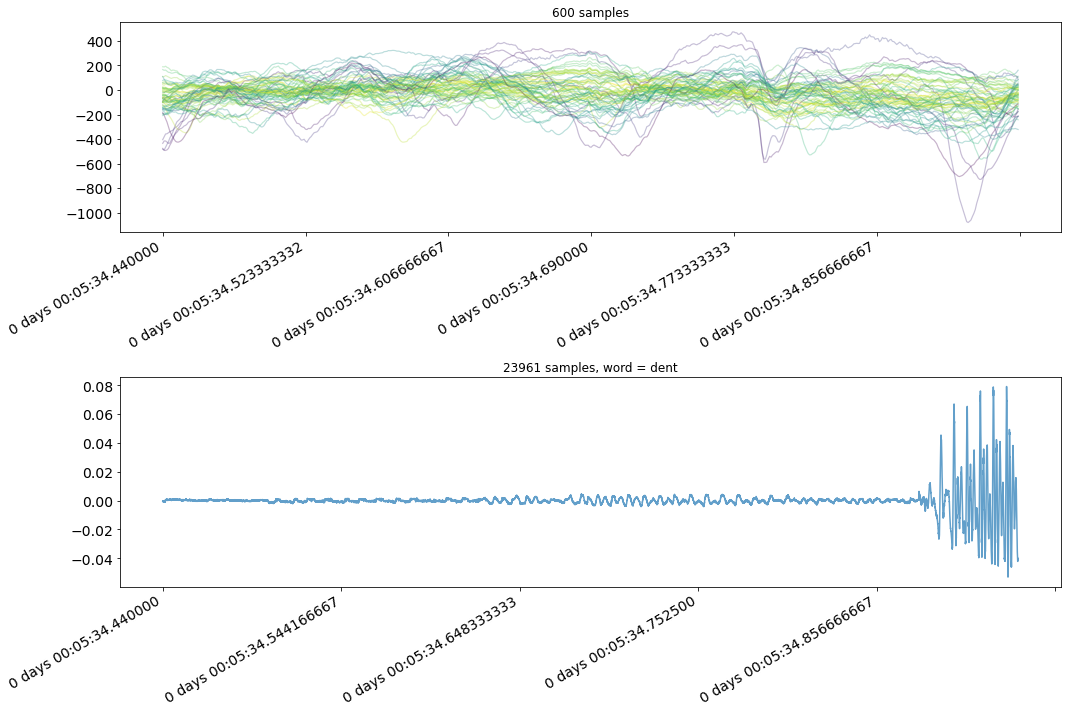

In [26]:
test_nww.sample_plot(5);

***

## Example data access - Accessing audio

In [27]:
nww.flat_keys[0][1]

('Mayo Clinic', 19, 1, 1)

<AxesSubplot:>

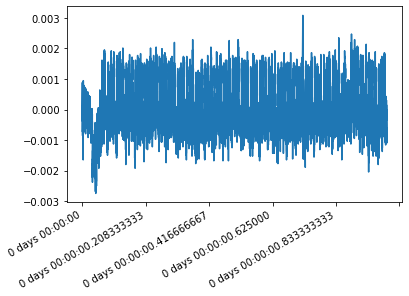

In [28]:
t_dmap = nww.data_map[nww.flat_keys[0][1]]
# show one second
t_dmap['audio'].iloc[:t_dmap['fs_audio']].plot()

In [29]:
import IPython

IPython.display.Audio(t_dmap['audio'].iloc[:t_dmap['fs_audio']*10].values, 
                      rate=t_dmap['fs_audio'])